In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
import math
import gc
import ipaddress
from urllib.parse import urlparse
from tldextract import extract
from sklearn.metrics import confusion_matrix

import sys
from pathlib import Path
d = Path().resolve().parent.parent
sys.path.insert(0, str(d))
import util.utils as utils
import util.plot_utils as plot_utils

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

np.set_printoptions(threshold=np.nan)

from sklearn.linear_model import LinearRegression



plt.rcParams["figure.figsize"] = (12,4)

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from datetime import datetime


InteractiveShell.ast_node_interactivity = "all"

### Features
- dates
    - dayofyear
    - weekofyear
    - dayofweek
    - dayofmonth (salary credit effect)
    - Holidays from date_info.csv
- Visitors and reserve visitors
- Take all hotels for model, even ones not in submmission file
- Area by lat long
- reserve visitors can be used by per restaurant per day to gain some kind of intuition
- LabelEncode Store info

In [2]:

def label_encode_field(df,field):
    df[field] = df[field].fillna('-1')
    encoded_df = df[field]
    label_encoder = LabelEncoder()
    encoder = label_encoder.fit(encoded_df.values)
    
    encoded_df=encoder.transform(df[field].fillna("-1").values)
    df[field+"_encoded"] = encoded_df
    return encoder

df_air_store_info = pd.read_csv("data/air_store_info.csv")
label_encode_field(df_air_store_info,"air_genre_name")
label_encode_field(df_air_store_info,"air_store_id")
label_encode_field(df_air_store_info,"air_area_name")
df_air_store_info["air_lat_long"]=df_air_store_info["latitude"].astype(str)+"_"+df_air_store_info["longitude"].astype(str)
label_encode_field(df_air_store_info,"air_lat_long")
df_hpg_store_info = pd.read_csv("data/hpg_store_info.csv")
df_store_id_relation = pd.read_csv("data/store_id_relation.csv")
df_air_visit_data = pd.read_csv("data/air_visit_data.csv")
df_date_info = pd.read_csv("data/date_info.csv")
df_date_info.drop(['day_of_week'], axis = 1, inplace = True)
df_date_info["visit_date"]=df_date_info["calendar_date"]
df_date_info.drop(['calendar_date'], axis = 1, inplace = True)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [3]:
def add_dates(df,date_col,date_format=None):
    timeseries = None
    if(date_format is None):
        timeseries = pd.to_datetime(df[date_col])
    else:
        timeseries = pd.to_datetime(df[date_col],format=date_format)
    df["dayofyear"] = timeseries.map(lambda x:x.dayofyear)
    df["dayofweek"] = timeseries.map(lambda x:x.dayofweek)
    df["weekofyear"] = timeseries.map(lambda x:x.weekofyear)
    df.loc[df["weekofyear"]==53,"weekofyear"] = 1
    df["dayofmonth"] = timeseries.map(lambda x:x.date().day)
    df["visit_date"] = timeseries.map(lambda x:str(x.date()))
    df = pd.merge(df,df_date_info,on="visit_date", how='left')
    #df.join(df_date_info,on='visit_date',how='left')
    return df
    
    

df_hpg_reserve = pd.read_csv("data/hpg_reserve.csv")

df_air_reserve = pd.read_csv("data/air_reserve.csv")

df_air_reserve = pd.merge(df_air_reserve,df_air_store_info,on='air_store_id', how='left')
df_air_reserve.drop(['reserve_datetime'], axis = 1, inplace = True)
df_hpg_reserve = pd.merge(df_hpg_reserve,df_hpg_store_info,on='hpg_store_id', how='left')
df_hpg_reserve.drop(['reserve_datetime'], axis = 1, inplace = True)

df_air_reserve=add_dates(df_air_reserve,"visit_datetime")
df_hpg_reserve=add_dates(df_hpg_reserve,"visit_datetime")



In [4]:
df_air_visit_data = pd.merge(df_air_visit_data,df_air_store_info,on='air_store_id', how='left')
df_air_visit_data = add_dates(df_air_visit_data,"visit_date")

In [5]:
sample_sub = pd.read_csv("data/sample_submission.csv")
len(sample_sub)

pred_ids = sample_sub.id.map(lambda x:x[:-11])
sample_sub["air_store_id"] = pred_ids
pred_dates = sample_sub.id.map(lambda x:x[-10:])
sample_sub["visit_date"] = pred_dates
sample_sub = add_dates(sample_sub,"visit_date")
sample_sub = pd.merge(sample_sub,df_air_store_info,on='air_store_id', how='left')
len(sample_sub)
sample_sub.head()


32019

32019

,id,visitors,air_store_id,visit_date,dayofyear,dayofweek,weekofyear,dayofmonth,holiday_flg,air_genre_name,air_area_name,latitude,longitude,air_genre_name_encoded,air_store_id_encoded,air_area_name_encoded,air_lat_long,air_lat_long_encoded
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,113,6,16,23,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,114,0,17,24,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,115,1,17,25,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,116,2,17,26,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,117,3,17,27,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68


In [6]:
df_air_visit_data.columns
output_column=["visitors"]
features = ["air_genre_name_encoded","air_store_id_encoded", 'air_area_name_encoded','air_lat_long_encoded', 'dayofyear', 'dayofweek', 'weekofyear',
       'dayofmonth', 'holiday_flg']
df_air_visit_data[features].dtypes

Index(['air_store_id', 'visit_date', 'visitors', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'air_genre_name_encoded',
       'air_store_id_encoded', 'air_area_name_encoded', 'air_lat_long',
       'air_lat_long_encoded', 'dayofyear', 'dayofweek', 'weekofyear',
       'dayofmonth', 'holiday_flg'],
      dtype='object')

air_genre_name_encoded    int64
air_store_id_encoded      int64
air_area_name_encoded     int64
air_lat_long_encoded      int64
dayofyear                 int64
dayofweek                 int64
weekofyear                int64
dayofmonth                int64
holiday_flg               int64
dtype: object

In [32]:
X = df_air_visit_data[features].values
y = df_air_visit_data[output_column]
X_pred = sample_sub[features].values

gc.collect()
xgr=xgb.XGBRegressor(n_estimators=400, learning_rate=0.4, gamma=0,
                           colsample_bytree=0.8, max_depth=8,n_jobs=4)
xgr.fit(X,y)

def xgr_predict(X):
    pred=xgr.predict(X)
    pred[pred<=0]=1
    return pred

7808

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
lr=LinearRegression(normalize=True,n_jobs=4)
lr.fit(X,y)
def lr_predict(X):
    pred=lr.predict(X)
    pred[pred<=0]=1
    return pred
    

    

/Users/ahemf/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=True)

In [33]:
df_air_mean_visits = df_air_visit_data.groupby(["air_store_id"],as_index=False).mean()

y_preds = xgr_predict(X_pred)
def loss(Y,A):
    length = len(Y)
    return np.sqrt(np.sum(np.square(np.log(Y) - np.log(A)))/length)
loss(df_air_visit_data["visitors"],df_air_mean_visits["visitors"])
loss(df_air_visit_data["visitors"],xgr_predict(X))
# loss(df_air_visit_data["visitors"],lr_predict(X))


0.07802537852290678

0.53777418263609456

In [34]:
len(y_preds)


32019

In [35]:
sample_sub["visitors"] = y_preds

In [36]:
sample_sub.to_csv("results/Features-Engg_XGB_initial_model_1.csv",index=False,columns=["id","visitors"])

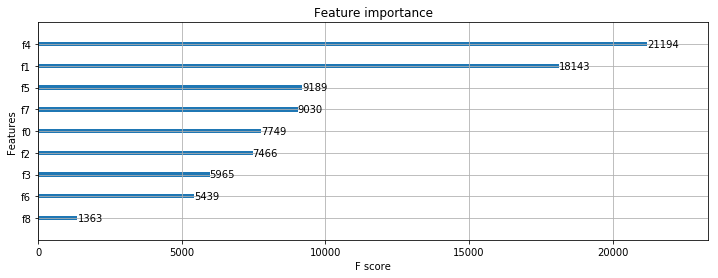

,feature,importance
4,dayofyear,24.777292
1,air_store_id_encoded,21.210457
5,dayofweek,10.742595
7,dayofmonth,10.556712
0,air_genre_name_encoded,9.059132
2,air_area_name_encoded,8.728285
3,air_lat_long_encoded,6.973509
6,weekofyear,6.358577
8,holiday_flg,1.593444


In [37]:
def plot_importance(model,df,features):
    from xgboost import plot_importance
    plot_importance(model)
    plt.show()
    fi=model.feature_importances_

    fn=df[features].columns.values

    df_i=pd.DataFrame({"feature":fn,"importance":fi})
    df_i["importance"] = df_i["importance"]*100
    return df_i.sort_values("importance",ascending=False)

plot_importance(xgr,df_air_visit_data,features)